In [ ]:
#GoogleDriveからマウント
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#ライブラリインポート
import numpy as np
import cv2
import os


In [ ]:
#データの読み込みとリサイズ
def load_and_resize_images(directory, img_height, img_width):
    images = []
    for filename in sorted(os.listdir(directory)):
        img = cv2.imread(os.path.join(directory, filename), cv2.IMREAD_GRAYSCALE)
        if img is not None:
            img_resized = cv2.resize(img, (img_width, img_height))
            img_resized = img_resized[..., np.newaxis]
            images.append(img_resized)
    return images

img_height, img_width = 128, 128

# 各データセットのディレクトリパスを指定
train_image_dir = "/content/drive/MyDrive/dataset_1000/実験/train/images"
train_mask_dir = "/content/drive/MyDrive/dataset_1000/実験/train/masks"

val_image_dir = "/content/drive/MyDrive/dataset_1000/実験/val/images"
val_mask_dir = "/content/drive/MyDrive/dataset_1000/実験/val/masks"

test_image_dir = "/content/drive/MyDrive/test/images"
test_mask_dir = "/content/drive/MyDrive/test/masks"

# 各データセットを読み込む
X_train = load_and_resize_images(train_image_dir, img_height, img_width)
y_train = load_and_resize_images(train_mask_dir, img_height, img_width)

X_val = load_and_resize_images(val_image_dir, img_height, img_width)
y_val = load_and_resize_images(val_mask_dir, img_height, img_width)

X_test = load_and_resize_images(test_image_dir, img_height, img_width)
y_test = load_and_resize_images(test_mask_dir, img_height, img_width)



In [ ]:
# 画像とマスクの形状を変更

X_train = np.array(X_train)
y_train = np.array(y_train)

X_val = np.array(X_val)
y_val = np.array(y_val)

X_test = np.array(X_test)
y_test = np.array(y_test)

In [ ]:
#正規化
# 画像とマスクの形状を変更し、正規化を行う（これはそのままでOK）
X_train = np.array(X_train) / 255.0
y_train = np.array(y_train) / 255.0
X_val = np.array(X_val) / 255.0
y_val = np.array(y_val) / 255.0
X_test = np.array(X_test) / 255.0
y_test = np.array(y_test) / 255.0

In [ ]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate

def unet_model(input_shape):
    inputs = Input(input_shape)

    # Encoder部分
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)

    # Decoder部分
    u5 = UpSampling2D((2, 2))(c4)
    u5 = Concatenate()([u5, c3])
    c5 = Conv2D(256, (3, 3), activation='relu', padding='same')(u5)

    u6 = UpSampling2D((2, 2))(c5)
    u6 = Concatenate()([u6, c2])
    c6 = Conv2D(128, (3, 3), activation='relu', padding='same')(u6)

    u7 = UpSampling2D((2, 2))(c6)
    u7 = Concatenate()([u7, c1])
    c7 = Conv2D(64, (3, 3), activation='relu', padding='same')(u7)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c7)

    return Model(inputs=[inputs], outputs=[outputs])

input_shape = (256, 256, 1)  # これは例として256x256のグレースケール画像を使用する場合のシェイプです。
model = unet_model(input_shape)


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 64)         640       ['input_1[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 128, 128, 64)         0         ['conv2d[0][0]']              
 D)                                                                                               
                                                                                                  
 conv2d_1 (Conv2D)           (None, 128, 128, 128)        73856     ['max_pooling2d[0][0]']   

In [ ]:
import tensorflow as tf

# IoU関数の定義
def iou(y_true, y_pred):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    union = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) - intersection
    iou = intersection / union
    return iou

# 精度を計算する関数
def precision(y_true, y_pred):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    true_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true_f * y_pred_f, 0, 1)))
    predicted_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_pred_f, 0, 1)))
    precision = true_positives / (predicted_positives + tf.keras.backend.epsilon())
    return precision

# 再現率を計算する関数
def recall(y_true, y_pred):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    true_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true_f * y_pred_f, 0, 1)))
    possible_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true_f, 0, 1)))
    recall = true_positives / (possible_positives + tf.keras.backend.epsilon())
    return recall

# F1スコアを計算する関数
def f1_score(y_true, y_pred):
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    return 2 * ((p * r) / (p + r + tf.keras.backend.epsilon()))

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# モデルのコンパイル
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=[iou, precision, recall, f1_score])

# 早期停止のコールバックを設定
early_stopping = EarlyStopping(
    monitor='val_loss',  # 監視する指標
    patience=10,         # 10エポック改善がなければ停止
    verbose=1,           # 進行状況のメッセージ表示
    restore_best_weights=True  # 最良のモデルの重みを復元
)


In [ ]:
# モデルのトレーニング（早期停止をコールバックとして追加）
history = model.fit(
    X_train, y_train,
    batch_size=32,
    epochs=50,  # 最大エポック数
    validation_data=(X_val, y_val),
    callbacks=[early_stopping]  # 早期停止のコールバックを追加
)

Epoch 1/50
100/100 [==============================] - 23s 77ms/step - loss: 0.3412 - iou: 0.7991 - precision: 0.9044 - recall: 0.9888 - f1_score: 0.9397 - val_loss: 0.2979 - val_iou: 0.7887 - val_precision: 0.9030 - val_recall: 0.9992 - val_f1_score: 0.9484
Epoch 2/50
100/100 [==============================] - 7s 75ms/step - loss: 0.2438 - iou: 0.8466 - precision: 0.9040 - recall: 0.9993 - f1_score: 0.9491 - val_loss: 0.2292 - val_iou: 0.8523 - val_precision: 0.9029 - val_recall: 0.9991 - val_f1_score: 0.9483
Epoch 3/50
100/100 [==============================] - 7s 72ms/step - loss: 0.2183 - iou: 0.8583 - precision: 0.9046 - recall: 0.9987 - f1_score: 0.9492 - val_loss: 0.2152 - val_iou: 0.8685 - val_precision: 0.9080 - val_recall: 0.9960 - val_f1_score: 0.9497
Epoch 4/50
100/100 [==============================] - 7s 75ms/step - loss: 0.1994 - iou: 0.8698 - precision: 0.9231 - recall: 0.9874 - f1_score: 0.9540 - val_loss: 0.1886 - val_iou: 0.8741 - val_precision: 0.9359 - val_recall: 0

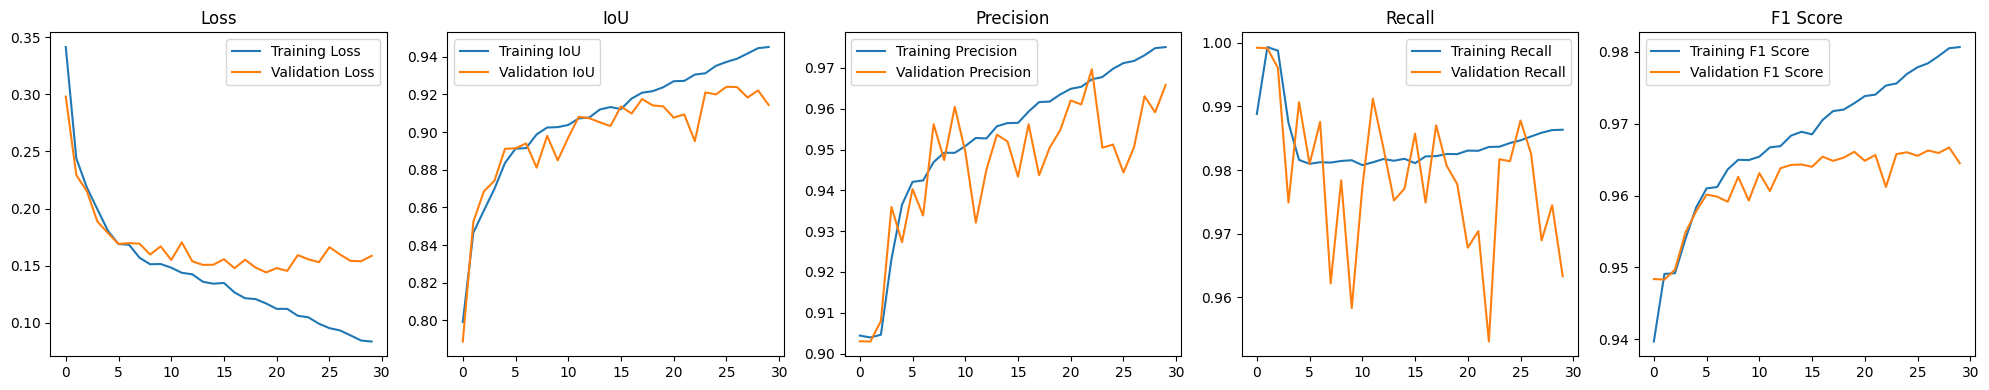

In [ ]:
import matplotlib.pyplot as plt
# 学習のロスと評価指標の履歴をプロット
plt.figure(figsize=(20, 4))

# ロスの履歴をプロット
plt.subplot(1, 5, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

# IoUの履歴をプロット
plt.subplot(1, 5, 2)
plt.plot(history.history['iou'], label='Training IoU')
plt.plot(history.history['val_iou'], label='Validation IoU')
plt.legend()
plt.title('IoU')

# 精度の履歴をプロット
plt.subplot(1, 5, 3)
plt.plot(history.history['precision'], label='Training Precision')
plt.plot(history.history['val_precision'], label='Validation Precision')
plt.legend()
plt.title('Precision')

# 再現率の履歴をプロット
plt.subplot(1, 5, 4)
plt.plot(history.history['recall'], label='Training Recall')
plt.plot(history.history['val_recall'], label='Validation Recall')
plt.legend()
plt.title('Recall')

# F1スコアの履歴をプロット（オプショナル）
plt.subplot(1, 5, 5)
plt.plot(history.history['f1_score'], label='Training F1 Score')
plt.plot(history.history['val_f1_score'], label='Validation F1 Score')
plt.legend()
plt.title('F1 Score')

plt.tight_layout()

# グラフを保存
plt.savefig('training_graphs.png')
plt.show()





In [ ]:
import os
from tensorflow.keras.models import Model

# 保存先のフォルダパスを指定
save_dir = '/content/drive/MyDrive/dataset_1000/model'

# 指定したフォルダが存在しない場合は作成
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# モデルの保存先のパスを指定
model_save_path = os.path.join(save_dir, 'unet_1000_低解像度_model.h5')

# モデルをHDF5形式で保存
model.save(model_save_path)


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
predictions = model.predict(X_test, batch_size = 8)

13/13 [==============================] - 1s 68ms/step


In [ ]:
threshold = 0.5
predictions_t = (predictions > threshold).astype(np.uint8)


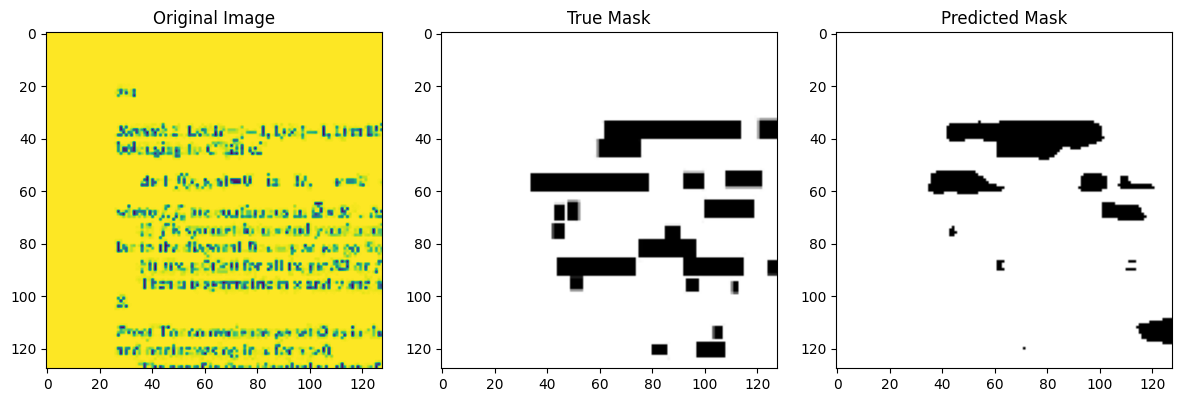

In [ ]:
import matplotlib.pyplot as plt

idx = 0  # 表示する画像のインデックス

plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.imshow(X_test[idx])
plt.title("Original Image")

plt.subplot(1, 3, 2)
plt.imshow(y_test[idx].squeeze(), cmap='gray')
plt.title("True Mask")

plt.subplot(1, 3, 3)
plt.imshow(predictions_t[idx].squeeze(), cmap='gray')
plt.title("Predicted Mask")

plt.tight_layout()
plt.savefig('result.png')
plt.show()
